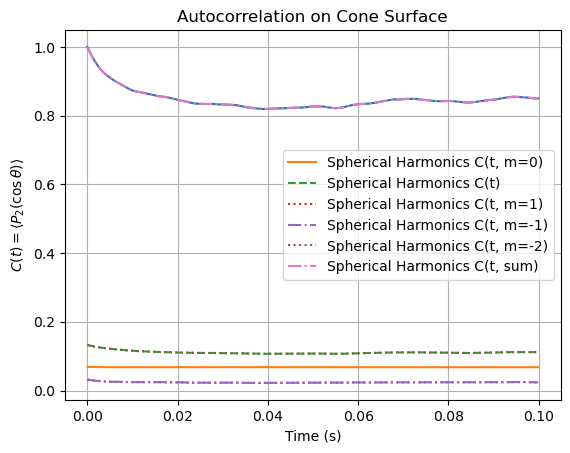

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=1e-4, num_steps=10000, axis=np.array([0, 0, 1])):
    """
    Simulate a unit vector hopping on a cone surface with fixed S2 and correlation time tau_c.
    
    Returns:
        vectors: (num_steps, 3) array of unit vectors
    """
    # Cone angle from S²
    cos_theta = np.sqrt((2 * S2 + 1) / 3)
    theta = np.arccos(cos_theta)

    # Ornstein-Uhlenbeck parameters for azimuthal diffusion
    gamma = 1 / tau_c
    sigma = np.sqrt(2 * gamma)  # Unit noise strength
    phi = 0.0
    axis = axis / np.linalg.norm(axis)

    # Rotation matrix to align cone with axis
    R_align = rotation_matrix_from_vectors(np.array([0, 0, 1]), axis)

    vectors = np.zeros((num_steps, 3))

    for i in range(num_steps):
        # Update azimuthal angle using Ornstein-Uhlenbeck process
        dphi = -gamma * phi * dt + sigma * np.sqrt(dt) * np.random.randn()
        phi += dphi

        # Point on cone with fixed θ and current φ
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        vec_local = np.array([x, y, z])

        # Rotate to align cone with specified axis
        vec_global = R_align @ vec_local
        vectors[i] = vec_global

    return vectors

def rotation_matrix_from_vectors(a, b):
    """Find the rotation matrix that aligns vector a to vector b"""
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    v = np.cross(a, b)
    c = np.dot(a, b)
    if c == 1:
        return np.eye(3)
    if c == -1:
        # 180° rotation around arbitrary perpendicular axis
        perp = np.array([1, 0, 0]) if not np.allclose(a, [1, 0, 0]) else np.array([0, 1, 0])
        return rotation_matrix_from_vectors(a, np.cross(a, perp))
    s = np.linalg.norm(v)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    return np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))

def compute_autocorrelation(vectors):
    """Compute P2 autocorrelation function"""
    N = len(vectors)
    corr = []
    for tau in range(N // 10):
        dots = np.einsum('ij,ij->i', vectors[:-tau], vectors[tau:]) if tau > 0 else np.einsum('ij,ij->i', vectors, vectors)
        P2 = 1.5 * dots**2 - 0.5
        corr.append(np.mean(P2))
    return np.array(corr)

# Another way to compute autocorrelation using spherical harmonics
from scipy.special import sph_harm

def compute_sph_harm_autocorrelation(vectors, l=2, m=0):
    """
    Compute complex autocorrelation of Y_l^m spherical harmonics from vector trajectory.
    
    Parameters:
        vectors: (num_steps, 3) array of unit vectors
        l: degree of spherical harmonics
        m: order of spherical harmonics

    Returns:
        corr: autocorrelation values
    """
    N = len(vectors)
    theta = np.arccos(vectors[:, 2])  # z = cos(theta)
    phi = np.arctan2(vectors[:, 1], vectors[:, 0])  # arctangent of y/x

    Y_vals = sph_harm(m, l, phi, theta)

    corr = []
    for tau in range(N // 10):
        if tau == 0:
            c = np.abs(np.mean(Y_vals * np.conj(Y_vals)))  # Normalization
        else:
            c = np.mean(Y_vals[:-tau] * np.conj(Y_vals[tau:]))
        corr.append(np.real(c))  # or keep complex values
    return np.array(corr)

# === Example usage ===
vecs = simulate_vector_on_cone(S2=0.85, tau_c=0.01, axis=np.array([1, 0, 0]))
C_t = compute_autocorrelation(vecs)
C_t_1 = compute_sph_harm_autocorrelation(vecs, l=2, m=1)
C_t_m1 = compute_sph_harm_autocorrelation(vecs, l=2, m=-1)
C_t_m2 = compute_sph_harm_autocorrelation(vecs, l=2, m=-2)
C_t_2 = compute_sph_harm_autocorrelation(vecs, l=2, m=2)
c_t_0 = compute_sph_harm_autocorrelation(vecs, l=2, m=0)
C_t_sum = 4*np.pi/5*(
    C_t_2 + C_t_1 + C_t_m1 + C_t_m2 + c_t_0
)

# Plot
time = np.arange(len(C_t)) * 1e-4
plt.plot(time, C_t)
plt.plot(time, c_t_0, label='Spherical Harmonics C(t, m=0)', linestyle='-')
plt.plot(time, C_t_2, label='Spherical Harmonics C(t)', linestyle='--')
plt.plot(time, C_t_1, label='Spherical Harmonics C(t, m=1)', linestyle=':')
plt.plot(time, C_t_m1, label='Spherical Harmonics C(t, m=-1)', linestyle='-.')
plt.plot(time, C_t_m2, label='Spherical Harmonics C(t, m=-2)', linestyle=':')
plt.plot(time, C_t_sum, label='Spherical Harmonics C(t, sum)', linestyle='-.')

plt.legend()
plt.xlabel("Time (s)")
plt.ylabel(r"$C(t) = \langle P_2(\cos\theta) \rangle$")
plt.title("Autocorrelation on Cone Surface")
plt.grid()
plt.show()


In [3]:
from scipy.optimize import curve_fit

def correlation_model(t, S2, tau):
    return S2 + (1 - S2) * np.exp(-t / tau)

def fit_correlation_function(C_t, dt):
    t = np.arange(len(C_t)) * dt
    # Initial guesses: S2 ≈ C_t[-1], tau ≈ time when C_t drops to (1+S2)/2
    S2_guess = C_t[-1]
    half_max = (1 + S2_guess) / 2
    tau_guess = t[np.argmin(np.abs(C_t - half_max))] if np.any(C_t < half_max) else 0.01

    popt, pcov = curve_fit(correlation_model, t, C_t, p0=[S2_guess, tau_guess])
    S2_fit, tau_fit = popt
    return S2_fit, tau_fit, t, correlation_model(t, *popt)

Fitted S² = 0.8222
Fitted τ = 0.00604 s


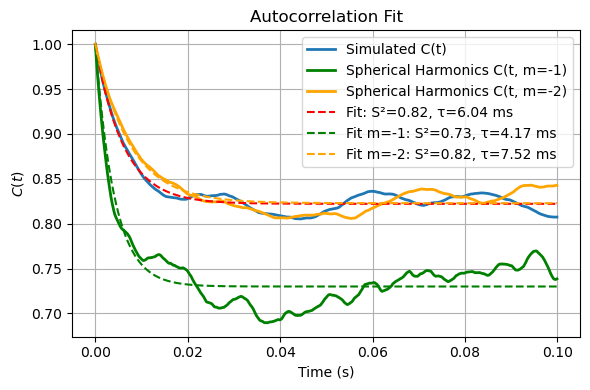

In [4]:
# Run simulation
dt = 1e-4
vecs = simulate_vector_on_cone(S2=0.85, tau_c=0.01, dt=dt)
C_t = compute_autocorrelation(vecs)

# Fit the autocorrelation
S2_fit, tau_fit, t_fit, C_fit = fit_correlation_function(C_t, dt)
#fit the C_t_m1 
C_t_m1_fit = compute_sph_harm_autocorrelation(vecs, l=2, m=-1)
# Fit the normilaized C_t_m1 as at time 0, it fitting equation =1
S2_m1_fit, tau_m1_fit, t_m1_fit, C_m1_fit = fit_correlation_function(C_t_m1/C_t_m1[0], dt)
# fit the C_t_m2
C_t_m2_fit = compute_sph_harm_autocorrelation(vecs, l=2, m=-2)
# Fit the normilaized C_t_m2 as at time 0, it fitting equation =1
S2_m2_fit, tau_m2_fit, t_m2_fit, C_m2_fit = fit_correlation_function(C_t_m2/C_t_m2[0], dt)

# Print results
print(f"Fitted S² = {S2_fit:.4f}")
print(f"Fitted τ = {tau_fit:.5f} s")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(C_t)) * dt, C_t, label='Simulated C(t)', lw=2)
plt.plot(np.arange(len(C_t_m1)) * dt, C_t_m1/C_t_m1[0], label='Spherical Harmonics C(t, m=-1)', lw=2, color='green')
plt.plot(np.arange(len(C_t_m2)) * dt, C_t_m2/C_t_m2[0], label='Spherical Harmonics C(t, m=-2)', lw=2, color='orange')
plt.plot(t_fit, C_fit, '--', label=f'Fit: S²={S2_fit:.2f}, τ={tau_fit*1e3:.2f} ms', color='red')
plt.plot(t_m1_fit, C_m1_fit, '--', label=f'Fit m=-1: S²={S2_m1_fit:.2f}, τ={tau_m1_fit*1e3:.2f} ms', color='green')
plt.plot(t_m2_fit, C_m2_fit, '--', label=f'Fit m=-2: S²={S2_m2_fit:.2f}, τ={tau_m2_fit*1e3:.2f} ms', color='orange')
#plt.plot(t_fit, correlation_model(t_fit, S2_fit, tau_fit), label='Fit Model', color='orange')
#plt.plot(t_m1_fit, correlation_model(t_m1_fit, S2_m1_fit, tau_m1_fit), label='Fit Model m=-1', color='purple')

plt.xlabel("Time (s)")
plt.ylabel(r"$C(t)$")
plt.title("Autocorrelation Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


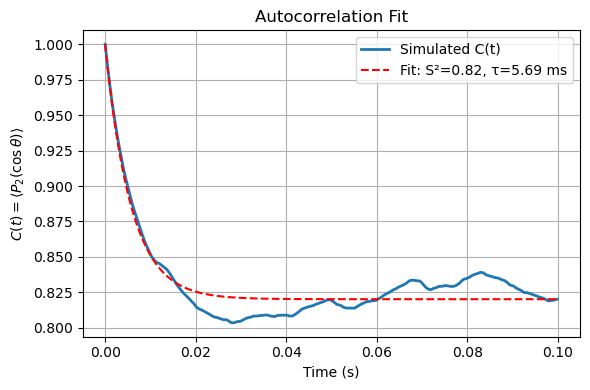

In [25]:
from scipy.special import sph_harm

def compute_sph_harm_autocorrelation(vectors, l=2, m=0):
    """
    Compute complex autocorrelation of Y_l^m spherical harmonics from vector trajectory.
    """
    N = len(vectors)
    theta = np.arccos(vectors[:, 2])  # z = cos(theta)
    phi = np.arctan2(vectors[:, 1], vectors[:, 0])  # arctangent of y/x

    Y_vals = sph_harm(m, l, phi, theta)

    corr = []
    for tau in range(N // 10):
        if tau == 0:
            c = np.abs(np.mean(Y_vals * np.conj(Y_vals)))  # Normalization
        else:
            c = np.mean(Y_vals[:-tau] * np.conj(Y_vals[tau:]))
        corr.append(np.real(c))  # or keep complex values
    return np.array(corr)
# === Example usage for spherical harmonics autocorrelation ===
vecs = simulate_vector_on_cone(S2=0.85, tau_c=0.01) 
C_sph = compute_sph_harm_autocorrelation(vecs, l=2, m=0)
#plot
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(C_t)) * dt, C_t, label='Simulated C(t)', lw=2)
plt.plot(t_fit, C_fit, '--', label=f'Fit: S²={S2_fit:.2f}, τ={tau_fit*1e3:.2f} ms', color='red')
#plt.plot(np.arange(len(C_sph)) * dt, C_sph, label='Spherical Harmonics C(t)', lw=2, color='green')
plt.xlabel("Time (s)")
plt.ylabel(r"$C(t) = \langle P_2(\cos\theta) \rangle$")
plt.title("Autocorrelation Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
